<img src="https://github.com/FarzadNekouee/Retail_Customer_Segmentation_Recommendation_System/blob/master/image.png?raw=true" width="2400">

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">

<h2 align="left"><font color=#ff6200>Problem:</font></h2>

<font color=#000000>The primary goal of this project is to segment customers based on their purchasing behavior to enable targeted marketing strategies and personalized engagement. Traditional segmentation methods (like KMeans) often require predefining the number of clusters and can struggle with noise or irregular cluster shapes. To overcome this, we use __DBSCAN__ (Density-Based Spatial Clustering of Applications with Noise) for its ability to detect arbitrarily shaped clusters and automatically handle outliers.

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">

<h2 align="left"><font color=#ff6200>Objectives:</font></h2>

<font color=#000000>

- **Data Extraction from SQL Database**: Retrieve customer transactional data directly from a relational database management system (DBMS), ensuring seamless integration with enterprise data sources.

    
- **Exploratory Data Analysis (EDA)**: Perform in-depth data exploration visualizations to uncover patterns and trends in customer purchasing behavior.

    
- **Statistical Insights**: Conduct descriptive and inferential statistical analysis to understand key customer metrics and distributional properties.

    
- **Data Preprocessing & Feature Selection**: Clean, transform, and scale features while removing irrelevant attributes and reducing dimensionality for better clustering outcomes.

    
- **Customer Segmentation using DBSCAN**: Apply DBSCAN to group customers based on density and behavior, allowing detection of arbitrarily shaped clusters and noise handling.

    
- **Cluster Profiling & Insight Extraction**: Analyze each cluster‚Äôs traits to derive actionable business insights and identify dominant purchasing patterns across segments.

    
- **Product Recommendation Engine**: Build a cluster-based recommendation system to suggest popular products to customers who have not purchased them yet, improving personalization and sales impact.


<h2 align="left"><font color=#ff6200>Let's get started:</font></h2>

<a id="setup"></a>
# <p style="background-color: #ff6200; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 1 | Setup & Imports</p>

In [1]:
# !pip install pyodbc
# !pip install dash
# !pip install yellowbrick
# !pip install tabulate

In [2]:
import pandas as pd
import numpy as np
import warnings
import pyodbc 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from urllib.request import urlopen
import json
import us
import matplotlib.pyplot as plt
import seaborn as sns
from dash import Dash, dcc, html, Input, Output
import pandas as pd
import plotly.express as px
from plotly.colors import sequential
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tabulate
from sklearn.cluster import DBSCAN

In [3]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)          # Show all columns
pd.set_option('display.width', None)                # Adjust width dynamically
pd.set_option('display.expand_frame_repr', False)   # Prevent column wrapping
warnings.filterwarnings('ignore')                   # Ignores all warnings

<a id="setup"></a>
# <p style="background-color: #ff6200; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Connecting to the SQL Server</p>

In [4]:
# Connection parameters
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=ZIAADHOSNY;'
    'DATABASE=Sales Analysis;'
    'Trusted_Connection=yes;'
)

In [5]:
# Establisihing a connection with the Server 
conn = pyodbc.connect(conn_str)

In [6]:
# Retreiving Data
query = "SELECT * FROM dbo.shopping_trends"
df = pd.read_sql(query, conn)

df.head()

Customer_ID  Age Gender Item_Purchased  Category  Purchase_Amount_USD       Location Size      Color  Season  Review_Rating Subscription_Status Payment_Method  Shipping_Type Discount_Applied Promo_Code_Used  Previous_Purchases Preferred_Payment_Method Frequency_of_Purchases
0            1   55   Male         Blouse  Clothing                   53       Kentucky    L       Gray  Winter            3.1                 Yes    Credit Card        Express              Yes             Yes                  14                    Venmo            Fortnightly
1            2   19   Male        Sweater  Clothing                   64          Maine    L     Maroon  Winter            3.1                 Yes  Bank Transfer        Express              Yes             Yes                   2                     Cash            Fortnightly
2            3   50   Male          Jeans  Clothing                   73  Massachusetts    S     Maroon  Spring            3.1                 Yes           Cash  Free Shipping              Yes             Yes                  23              Credit Card                 Weekly
3            4   21   Male        Sandals  Footwear                   90   Rhode Island    M     Maroon  Spring            3.5                 Yes         PayPal   Next Day Air              Yes             Yes                  49                   PayPal                 Weekly
4            5   45   Male         Blouse  Clothing                   49         Oregon    M  Turquoise  Spring            2.7                 Yes           Cash  Free Shipping              Yes             Yes                  31                   PayPal               Annually

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">

<h2 align="left"><font color=#ff6200>Dataset Description:</font></h2>

| __Variable__   | __Description__ |
|     :---       |       :---      |      
| __Customer_ID__| Unique Identifier for each customer. |
| __Age__        | Customer's Age. |
| __Gender__     | Customer's Gender.|
| __Item_Purchased__| Item Purchased per customer.|
| __Category__| Category of each product.|
|__Purchase_Amount_USD__| Price per each purchased product.|
|__Location__|Store's state.|
|__Size__|Product's size.|
|__Color__|Product's color.|
|__Season__| Season, which the item was purchased in.|
|__Review_Rating__| Customer's rating out of 5.|
|__Subscription_Status__| Binary Feature that states whether a customer is subscriped or not.|
|__Payment_Method__|The method the customer payed in.|
|__Shipping_Type__| The way, the order was shipped by.|
|__Discount_Applied__| Binary Feature that states whether a discount is applied or not.|
|__Promo_Code_Used__| Binary Feature that states whether a promo code is applied by the customer or not.|
|__Previous_Purchases__| Previous Purchases done by the customer.|
|__Preferred_Payment_Method__|Customer's preferred payment method.|
|__Frequency_of_Purchases__|Determines how freqenent a customer purchases from the store.|

In [7]:
df.shape

(3900, 19)

<a id="setup"></a>
# <p style="background-color: #ff6200; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 | Exploratory Data Analysis</p>

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Afterward, I am going to gain a more thorough understanding of the dataset before proceeding to the data cleaning and transformation stages.

<a id="setup"></a>
## <p style="background-color: #ff6200; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Statistical Analysis</p>

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

First, I will perform a statistical analysis to understand the structure, types and correlation of data columns:

In [8]:
df.describe()

Customer_ID          Age  Purchase_Amount_USD  Review_Rating  Previous_Purchases
count  3900.000000  3900.000000          3900.000000    3900.000000         3900.000000
mean   1950.500000    44.068462            59.764359       3.749949           25.351538
std    1125.977353    15.207589            23.685392       0.716223           14.447125
min       1.000000    18.000000            20.000000       2.500000            1.000000
25%     975.750000    31.000000            39.000000       3.100000           13.000000
50%    1950.500000    44.000000            60.000000       3.700000           25.000000
75%    2925.250000    57.000000            81.000000       4.400000           38.000000
max    3900.000000    70.000000           100.000000       5.000000           50.000000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item_Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase_Amount_USD       3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review_Rating             3900 non-null   float64
 11  Subscription_Status       3900 non-null   object 
 12  Payment_Method            3900 non-null   object 
 13  Shipping_Type             3900 non-null   object 
 14  Discount

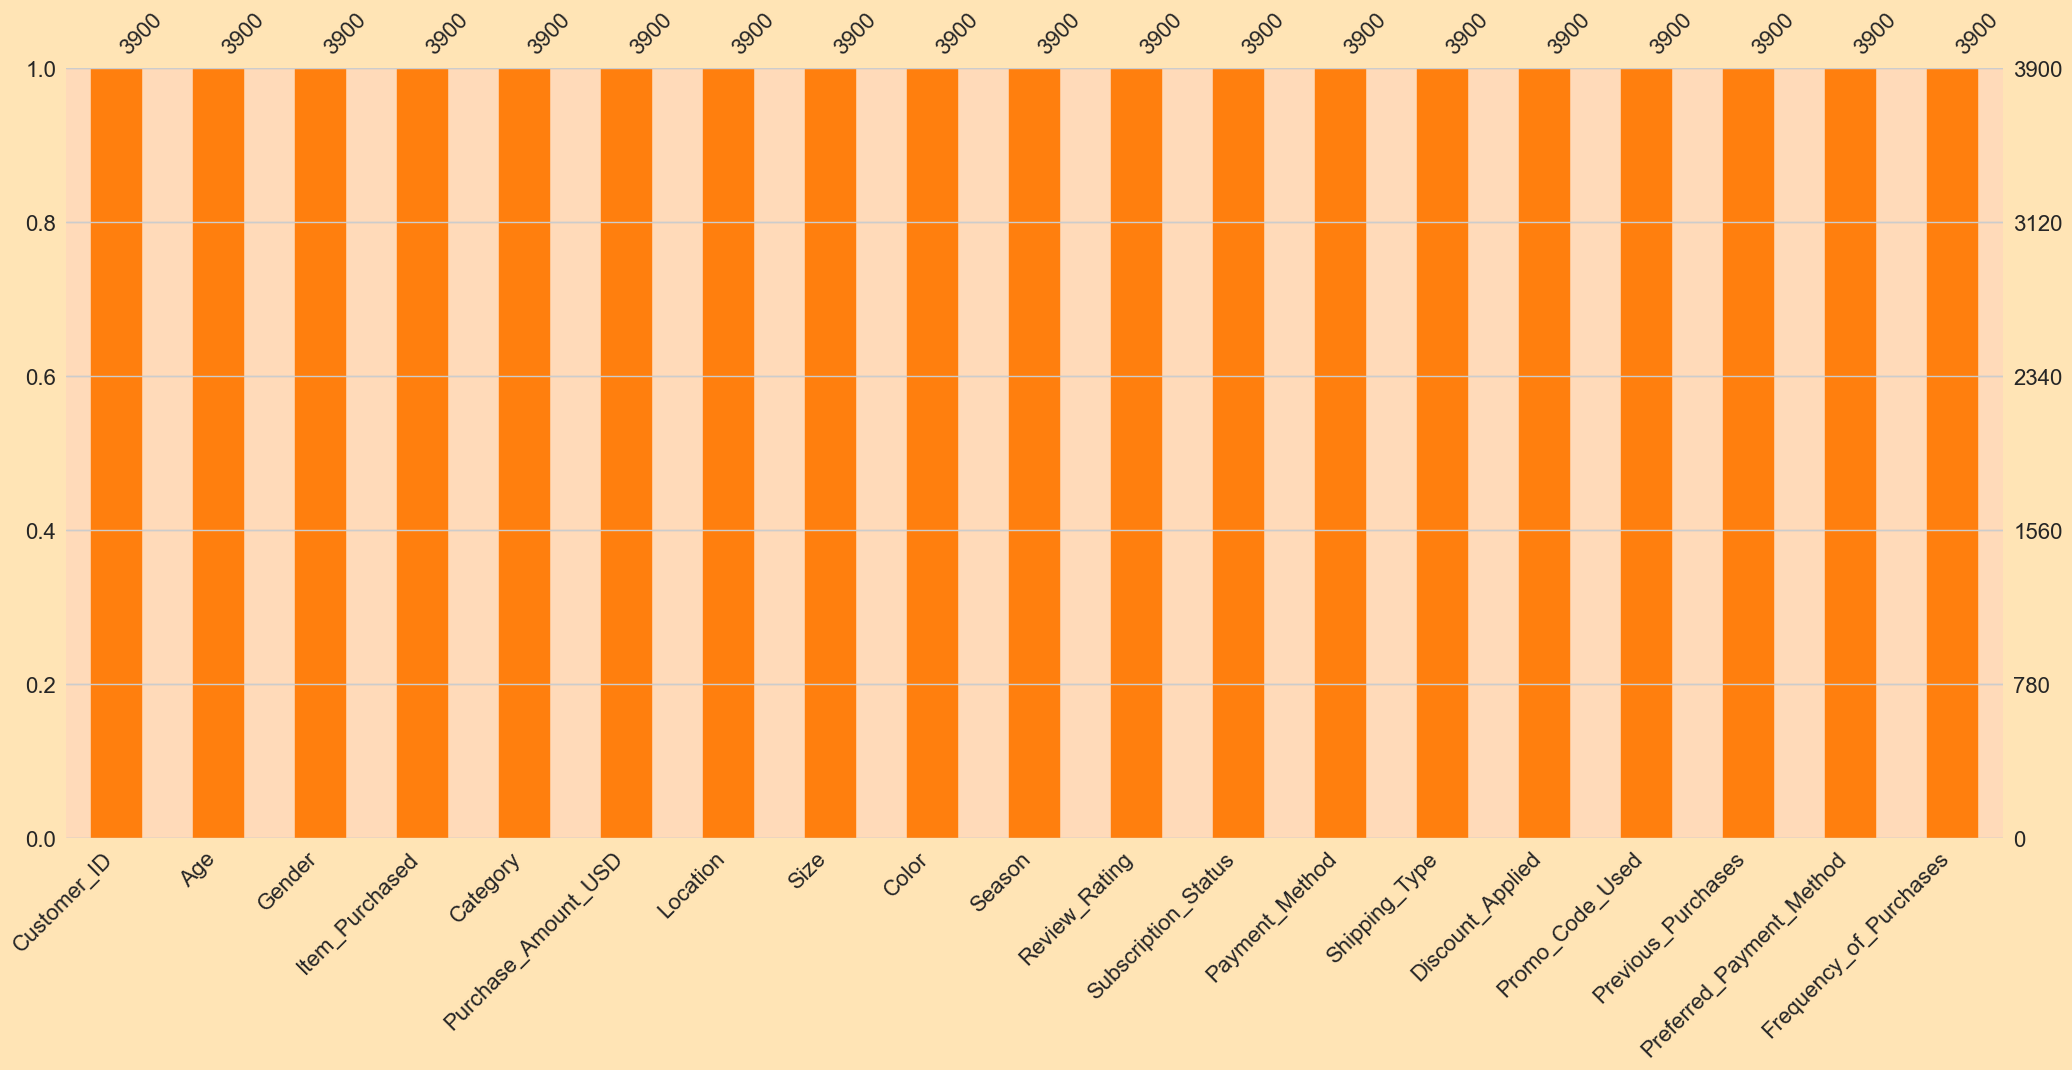

In [ ]:
# Create the plot
ax = msno.bar(df)

# Manually update the colors
for bar in ax.patches:
    bar.set_color("#ff7f0e")  

# Optional: change background or text colors
ax.set_facecolor("peachpuff")
ax.figure.set_facecolor("moccasin")

plt.show()


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

It appears that there are no null values present in the data. So, I will perform more visualizations to gain a deeper understanding of the features.

In [11]:
def num_stat_analysis(col: str, color: str):

  fig = make_subplots(1, 2, subplot_titles=(
      f'{col} Distribution by Customer ID',
      f'{col} Box Plot'
  ), shared_yaxes=True)

  fig.add_trace(
      px.scatter(
          x=df['Customer_ID'],
          y=df[col],
          color_discrete_sequence=[color]
      ).data[0],
      row=1, col=1
  )

  fig.add_trace(
      px.box(
          y=df[col],
          color_discrete_sequence=[color]
      ).data[0],
      row=1, col=2
      )

  fig.update_layout(
        title_text='<b>Statistical Analysis</b>',  # Bold using HTML
        title_x=0.5,
        title_font=dict(
            size=20,
            family='Arial',
            color='black'
        ),
        width=1000,
        height=500,
        paper_bgcolor='peachpuff',   # Outer background
        plot_bgcolor='moccasin',     # Inner plot area background

        xaxis=dict(
            showgrid=False,
            showticklabels=True,
            zeroline=False,
            visible=True,
        ),
        yaxis=dict(
            showgrid=False,
            showticklabels=True,
            zeroline=False,
            visible=True,
        ),
        xaxis2=dict(
            showgrid=False,
            showticklabels=True,
            zeroline=False,
            visible=True,
        ),
        yaxis2=dict(
            showgrid=False,
            showticklabels=True,
            zeroline=False,
            visible=True,
        ),
    )

  fig.show()

In [12]:
num_feats = df.select_dtypes(include=['int', 'float']).columns

for feat in num_feats:
  if feat == 'Customer_ID':
    continue
  num_stat_analysis(feat, '#ff7f0e')

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

For the __Continuous Features__, it appears that there are no anomalies among the data, so the insights brought to us by the __`describe`__ function is accurate and can be useful to us. 

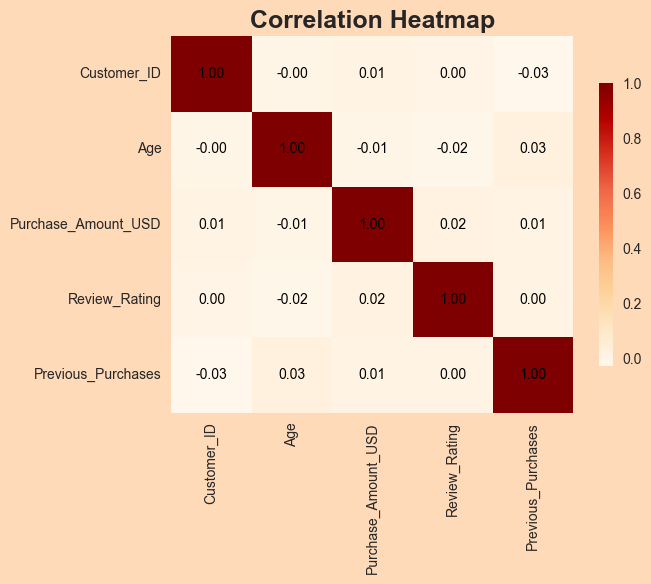

In [13]:
# Correlational Heatmap
num_cols = df.select_dtypes(include=['int', 'float']).columns.tolist()

plt.figure(figsize=(7, 6), facecolor='peachpuff')
heatmap = sns.heatmap(
    df[num_cols].corr(method='kendall'), # kendall's coefficient capture linear & non-linear correlations
    annot=True,
    annot_kws={"size": 10, "color": "black",},
    cmap='OrRd',
    cbar_kws={"shrink": 0.75},
    fmt=".2f",
)

# Set tick labels font
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10,)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10,)

# Set title font
plt.title('Correlation Heatmap', fontdict=dict(fontsize=18, weight='bold'))

plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

There are __no correaltion__ what so ever between the numerical features.

In [14]:
def cat_stat_analysis(col: str):
    plotdf = df.groupby(col)['Customer_ID'].count()
    
    or_rd_colors = sequential.OrRd


    # Slice to match number of categories
    colors_to_use = or_rd_colors

    fig = go.Figure(data=[
        go.Pie(
            labels=plotdf.index,
            values=plotdf.values,
            hole=0.5,
            marker=dict(colors=colors_to_use)
        )
    ])

    # Get the most frequent category name for annotation
    top_category = plotdf.idxmax()

    fig.update_layout(
        title_text=f'<b>Statistical Analysis for {col}</b>',
        title_x=0.5,
        title_font=dict(
            size=20,
            family='Arial',
            color='black'
        ),
        paper_bgcolor='peachpuff',
        width=1000,
        height=500,
        annotations=[dict(
            text=top_category,
            x=0.5, y=0.5,
            font_size=20,
            showarrow=False
        )]
    )

    fig.show()


In [15]:
cat_feats = df.select_dtypes(include='object').columns

for feat in cat_feats:
  cat_stat_analysis(feat)

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

For the __Categorical\Discrete Features__, it appears that there are imbalances among the values of some features, like:

* __Gender__
* __Clothing__
* __Size__
* __Subscription_Status__
* __Discount_Applied__
* __Promo_Code_Used__

<a id="setup"></a>
## <p style="background-color: #ff6200; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Data Insights</p>

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Since, there is no correaltion between the numerical features, i will turn the __age__ feature into a __categorical feature__.

In [16]:
# Age
def age_to_cat(x: int):
  if x < 20:
    return '<20'   # Age Group 1
  elif 20 <= x < 40:
    return '20-40' # Age Group 2
  elif 40 <= x <= 60:
    return '40-60' # Age Group 3
  else:
    return '60<'   # Age Group 4

df['age_cat'] = df['Age'].apply(age_to_cat)
df['age_cat'].unique()

array(['40-60', '<20', '20-40', '60<'], dtype=object)

In [17]:
plot_df = df.groupby('age_cat')['Purchase_Amount_USD'].sum().sort_values(ascending=False)

fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=plot_df.values,
        y=plot_df.index,
        orientation='h',
        text=[f"{val:.1f}k" for val in plot_df.values/1000],
        textposition='outside',
        textangle=0,
        textfont=dict(
            size=12,
            color='rgb(82, 82, 82)',
            family='Arial',
            weight='bold'
        ),
        marker=dict(
            color=plot_df.values,
            colorscale='OrRd',
            colorbar=dict(title="Purchased<br>Amount<br>(USD)"),
        )

   )
)

fig.update_layout(
    height=800,
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='chocolate',
        linewidth=5,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            weight='bold',
            color='rgb(82, 82, 82)',
        ),
    ),
        yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        tickfont=dict(
            family='Arial',
            size=14,
            weight='bold',
            color='rgb(82, 82, 82)',
        ),
    ),
    title_text=f'<b>Profit per Age Category</b>',
    title_font=dict(
            size=20,
            family='Arial',
            color='black'
        ),
        paper_bgcolor='peachpuff',   # Outer background
        plot_bgcolor='peachpuff',     # Inner plot area background
)

fig.show()

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

The 2 age groups (__`20-40`__ & __`40-60`__) contribute over __77%__ of the store's total sales while the age group (__`<20`__) contributes only __3.8%__ of the store's total sales.

In [18]:
def product_per_age(age: str):

  fig = make_subplots(1, 2, subplot_titles=(
      f'Most Purchased Category for {age}',
      f'Most Purchased Item for {age}'
  ),
  specs=[[{'type': 'domain'}, {'type': 'domain'}]],
  shared_yaxes=True)

  plot_df = df[df['age_cat'] == age].groupby('Category')['Purchase_Amount_USD'].sum().sort_values(ascending=False)

  or_rd_colors = sequential.OrRd[::-1]

  fig.add_trace(
      go.Pie(
          labels=plot_df.index.tolist(),
          values=plot_df.values.tolist(),
          hole=.5,
          showlegend=False,
          marker=dict(colors=or_rd_colors)
      ),
      row=1, col=1
  )

  cond1 = (df['age_cat'] == age)
  most_purchased_cat = df[df['age_cat'] == age].groupby('Category')['Purchase_Amount_USD'].sum().sort_values(ascending=False).index[0]
  cond2 = (df['Category'] == most_purchased_cat)

  plot_df = df[cond1 & cond2].groupby('Item_Purchased')['Purchase_Amount_USD'].sum().sort_values(ascending=False).reset_index()

  parents, labels = [], []
  for item in plot_df['Item_Purchased']:
    labels.append(item)
    parents.append(most_purchased_cat)

  fig.add_trace(go.Treemap(
    labels=labels,
    parents=parents,
    values=plot_df['Purchase_Amount_USD'].tolist(),
    marker=dict(
            colors=plot_df['Purchase_Amount_USD'].tolist(),
            colorscale='OrRd',
            colorbar=dict(
                title="Purchase<br>Amount<br>(USD)"
            )
        ),
  ), row=1, col=2)


  fig.update_layout(
        title_text=f'<b>Product Analysis per Age Group ({age})</b>',
        title_x=0.5,
        title_font=dict(
            size=20,
            family='Arial',
            color='black'
        ),
        width=1000,
        height=500,
              paper_bgcolor='peachpuff',   # Outer background

        annotations=[dict(text=most_purchased_cat, x=0.225, y=0.46, font_size=20, showarrow=False)]
    )

  fig.show()

for age in df['age_cat'].unique():
  product_per_age(age)

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

The Categories follow a certain order among all age groups:
1) Clothing
2) Accessories
3) Footwear
4) Outwear
  
It appears that __Clothing__ is the most liked category of all age groups with it's products being sorted in various ways across all age groups.  

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

<font color=#000000>

Now to analyze each gender's most favourite product per category.

In [19]:
def gender_per_cat(gender: str):
    plot_df = df.groupby(['Gender', 'Category', 'Item_Purchased'])['Purchase_Amount_USD'].sum().reset_index()
    gender_plot_df = plot_df[plot_df['Gender'] ==  gender]

    fig = go.Figure()

    for category in gender_plot_df['Category'].unique():
        subset = gender_plot_df[gender_plot_df['Category'] == category]
        
        cash = subset['Purchase_Amount_USD'].tolist()
        max_cash_index = cash.index(max(cash))
        
        colors = ['lightslategray'] * len(subset)
        colors[max_cash_index] = '#ff7f0e'
        
        fig.add_trace(
            go.Bar(
                x=subset['Item_Purchased'],
                y=subset['Purchase_Amount_USD'],
                name=category,
                marker_color=colors,
                text=[category] * len(subset),  
                textposition='inside'
            )
        )
        
    fig.update_layout(
        barcornerradius=7,
        title=f'{gender} Purchases Grouped by Category',
        xaxis_title='Item Purchased',
        yaxis_title='Purchase Amount (USD)',
        showlegend=False,
        paper_bgcolor='peachpuff',   # Outer background
        plot_bgcolor='moccasin',     # Inner plot area background
        yaxis=dict(
            showgrid=False
        )
    )
        
    fig.show()

for gender in ['Male', 'Female']:
    gender_per_cat(gender)

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Now to analyze the most purchased color per product.

In [20]:
plot_df = df.groupby(['Item_Purchased', 'Color'])['Purchase_Amount_USD'].sum().reset_index()

fig = px.bar(
    plot_df,
    x="Color",
    y="Purchase_Amount_USD",
    color="Purchase_Amount_USD",
    color_continuous_scale='OrRd',  
    animation_frame="Item_Purchased", 
    range_y=[0, plot_df["Purchase_Amount_USD"].max() + 20],
    title="Color per Products",
    labels={'Purchase_Amount_USD': 'Sales ($)'},
)

fig.update_layout(
    transition={"duration": 500},
    paper_bgcolor='peachpuff',   # Outer background
    plot_bgcolor='moccasin',     # Inner plot area background
    xaxis=dict(
        title="Color",
    ),
    yaxis=dict(
        title="Sales",
        showgrid=False
    )
)

fig.show()


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Now to analyze which season contributes the most to the store's success.

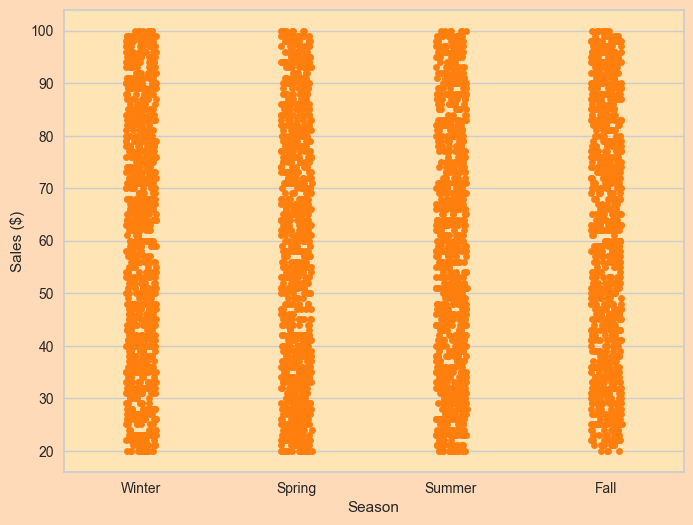

In [21]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='peachpuff')  # outer (paper)
ax.set_facecolor('moccasin')  # inner (plot area)

sns.stripplot(data=df, x='Season', y='Purchase_Amount_USD', color='#ff7f0e')
plt.ylabel('Sales ($)')
plt.show()

<h3 align="left"><font color=#ff6200>To Analyze the Rest of the Categorical Feats:</font></h2>

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

<h3 align="left"><font color=#ff6200>Approach:</font></h3>

<font color=#000000>

* I will transform both __`Payment_Method`__ and __`Preferred_Payment_Method`__ into one categorical feature called __Is_Preferred_Payment_Method__ (is_ppm).
* Since there are 2 values of the same meaning in the __`Frequency_of_Purchases`__ feature (`Every 3 Months` & `Quarterly`), I will be replacing them both with __`Quarterly`__ only.
* Finding the Conditional Probability of vital Categorical Features and their affect on the frequency of customers' purchases, <i><b>__P(Frequency_of_Purchases | is_ppm, Shipping_Type, Discount_Applied, Promo_Code_Used, Subscription_Status)__</i></b>

In [22]:
df['is_ppm'] = df.apply(lambda x: 'Yes' if x['Payment_Method'] == x['Preferred_Payment_Method'] else 'No', axis=1)

In [23]:
df['Frequency_of_Purchases'][df['Frequency_of_Purchases'] == 'Every 3 Months'] = 'Quarterly'

In [24]:
# Compute conditional ECDF
prob = df.groupby(['is_ppm', 'Shipping_Type', 'Discount_Applied',
                   'Promo_Code_Used', 'Subscription_Status', 'Frequency_of_Purchases']).size().reset_index(name='count')

prob['prob'] = prob.groupby(['is_ppm', 'Shipping_Type', 'Discount_Applied',
                             'Promo_Code_Used', 'Subscription_Status'])['count'].transform(lambda x: x / x.sum())

prob = prob.sort_values(by=['is_ppm', 'Shipping_Type', 'Discount_Applied',
                            'Promo_Code_Used', 'Subscription_Status', 'prob'])

prob['ecdf'] = prob.groupby(['is_ppm', 'Shipping_Type', 'Discount_Applied',
                             'Promo_Code_Used', 'Subscription_Status'])['prob'].cumsum()

# Start Dash app
app = Dash(__name__)

app.layout = html.Div([
    html.H2("Conditional Probability by Frequency of Purchases",     
            style={
        'color': '#8B4513',            
        'fontSize': '18px',
        'fontWeight': 'bold',
        'fontFamily': 'Arial',
        'marginBottom': '8px',
        'display': 'block',
        'textAlign': 'center'         

    }),

    html.Label("Preferred Payment Method",
                  style={
        'color': '#8B4513',            # SaddleBrown text
        'fontSize': '18px',
        'fontWeight': 'bold',
        'fontFamily': 'Arial',
        'marginBottom': '8px',
        'display': 'block'
    }),
    dcc.Dropdown(
        id='is_ppm',
        options=[{"label": str(val), "value": val} for val in sorted(prob['is_ppm'].unique())],
        value=sorted(prob['is_ppm'].unique())[0],
        style={
            'backgroundColor': 'peachpuff',
            'color': 'black',
            'border': '1px solid #ffbf80',
            'fontWeight': 'bold',
            'fontFamily': 'Arial',
        }
    ),

    html.Label("Discount Applied",
                  style={
        'color': '#8B4513',            # SaddleBrown text
        'fontSize': '18px',
        'fontWeight': 'bold',
        'fontFamily': 'Arial',
        'marginBottom': '8px',
        'display': 'block'
    }),
    dcc.Dropdown(
        id='Discount_Applied',
        options=[{"label": val, "value": val} for val in sorted(prob['Discount_Applied'].unique())],
        value=sorted(prob['Discount_Applied'].unique())[0],
        style={
            'backgroundColor': 'peachpuff',
            'color': 'black',
            'border': '1px solid #ffbf80',
            'fontWeight': 'bold',
            'fontFamily': 'Arial',
        }
    ),

    html.Label("Promo Code Used",
                  style={
        'color': '#8B4513',            
        'fontSize': '18px',
        'fontWeight': 'bold',
        'fontFamily': 'Arial',
        'marginBottom': '8px',
        'display': 'block'
    }),
    dcc.Dropdown(
        id='Promo_Code_Used',
        options=[{"label": val, "value": val} for val in sorted(prob['Promo_Code_Used'].unique())],
        value=sorted(prob['Promo_Code_Used'].unique())[0],
        style={
            'backgroundColor': 'peachpuff',
            'color': 'black',
            'border': '1px solid #ffbf80',
            'fontWeight': 'bold',
            'fontFamily': 'Arial',
        }
    ),

    html.Label("Subscription Status",
                  style={
        'color': '#8B4513',            # SaddleBrown text
        'fontSize': '18px',
        'fontWeight': 'bold',
        'fontFamily': 'Arial',
        'marginBottom': '8px',
        'display': 'block'
    }),
    dcc.Dropdown(
        id='Subscription_Status',
        options=[{"label": val, "value": val} for val in sorted(prob['Subscription_Status'].unique())],
        value=sorted(prob['Subscription_Status'].unique())[0],
        style={
            'backgroundColor': 'peachpuff',
            'color': 'black',
            'border': '1px solid #ffbf80',
            'fontWeight': 'bold',
            'fontFamily': 'Arial',
        }
    ),

    html.Label("Shipping Type",     
               style={
                    'color': '#8B4513',            # SaddleBrown text
                    'fontSize': '25px',
                    'fontWeight': 'bold',
                    'fontFamily': 'Arial',
                    'marginBottom': '8px',
                    'display': 'block'
                }),
    dcc.Dropdown(
        id='Shipping_Type',
        options=[{"label": val, "value": val} for val in sorted(prob['Shipping_Type'].unique())],
        value=sorted(prob['Shipping_Type'].unique())[0],
        style={
            'backgroundColor': 'peachpuff',
            'color': 'black',
            'border': '1px solid #ffbf80',
            'fontWeight': 'bold',
            'fontFamily': 'Arial',
        }
    ),

    dcc.Graph(id='ecdf-plot')
])


@app.callback(
    Output('ecdf-plot', 'figure'),
    [Input('is_ppm', 'value'),
     Input('Shipping_Type', 'value'),
     Input('Discount_Applied', 'value'),
     Input('Promo_Code_Used', 'value'),
     Input('Subscription_Status', 'value')]
)

def update_ecdf(is_ppm, shipping, discount, promo, sub):
    filtered = prob[
        (prob['is_ppm'] == is_ppm) &
        (prob['Shipping_Type'] == shipping) &
        (prob['Discount_Applied'] == discount) &
        (prob['Promo_Code_Used'] == promo) &
        (prob['Subscription_Status'] == sub)
    ]

    fig = px.line(
        filtered,
        x='Frequency_of_Purchases',
        y='prob',
        markers=True,
        text='prob',
        labels={
            'Frequency_of_Purchases': 'Frequency of Purchases',
            'prob': 'Conditional Probability'
        },
        title='<b>Conditional Probability: Frequency of Purchases</b>',
        line_shape='spline'
    )

    fig.update_traces(
        texttemplate='%{text:.2f}',
        textposition='top right',
        line=dict(color='#d62728', width=3, dash='dashdot'),
        marker=dict(color='#d62728', size=10, symbol='diamond', line=dict(color='black', width=1))
    )

    fig.update_layout(
        paper_bgcolor='peachpuff',
        plot_bgcolor='moccasin',
        xaxis=dict(
            title=dict(
                text='Frequency of Purchases',
                font=dict(size=14, color='rgb(82,82,82)')
            ),
            tickfont=dict(size=12, color='rgb(82,82,82)'),
            showgrid=True,
            gridcolor='navajowhite',
            showline=True,
            linecolor='saddlebrown',
        ),
        yaxis=dict(
            title=dict(
                text='Probability',
                font=dict(size=14, color='rgb(82,82,82)')
            ),
            tickfont=dict(size=12, color='rgb(82,82,82)'),
            showgrid=True,
            gridcolor='navajowhite',
            showline=True,
            linecolor='saddlebrown',
        ),
    )

    return fig


# Run app
app.run(debug=True)


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

<h3 align="left"><font color=#ff6200>Key Observation:</font></h3>

<font color=#000000>

__Discount_Applied__ is an __OR__ product of both __Subscription_Status__ & __Promo_Code_Used__, so you need to actually plug in a combination of values that makes the probability graph appear.

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Performance of each state:

In [25]:
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    states = json.load(response)

plot_df = df.groupby('Location')['Purchase_Amount_USD'].sum().reset_index()

fig = px.choropleth(
    plot_df,
    geojson=states,
    locations='Location',
    featureidkey='properties.name',
    color='Purchase_Amount_USD',
    color_continuous_scale='OrRd',
    scope="usa",
    labels={'Purchase_Amount_USD': 'Purchase ($)'},
    title="Purchase Amount by State"
)

fig.update_geos(fitbounds="locations", visible=False, projection_type="albers usa",)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},)
fig.show()


<a id="setup"></a>
# <p style="background-color: #ff6200; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 4 | Customer Segmentation & Recommendations</p>

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

I will drop the __`age_cat`__ feature because i already have a more detailed continuous feature.

In [26]:
df.drop('age_cat', axis=1, inplace=True)

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Preprocessing for the Segmentation:

In [27]:
# encoding stuff
le = LabelEncoder()
cleaned = df.copy()
cat_feats = df.select_dtypes(include='object').columns

for feature in cat_feats:
    cleaned[feature] = le.fit_transform(cleaned[feature])

cleaned.head()

Customer_ID  Age  Gender  Item_Purchased  Category  Purchase_Amount_USD  Location  Size  Color  Season  Review_Rating  Subscription_Status  Payment_Method  Shipping_Type  Discount_Applied  Promo_Code_Used  Previous_Purchases  Preferred_Payment_Method  Frequency_of_Purchases  is_ppm
0            1   55       1               2         1                   53        16     0      7       3            3.1                    1               2              1                 1                1                  14                         5                       2       0
1            2   19       1              23         1                   64        18     0     12       3            3.1                    1               0              1                 1                1                   2                         1                       2       0
2            3   50       1              11         1                   73        20     2     12       1            3.1                    1               1              2                 1                1                  23                         2                       5       0
3            4   21       1              14         2                   90        38     1     12       1            3.5                    1               4              3                 1                1                  49                         4                       5       1
4            5   45       1               2         1                   49        36     1     21       1            2.7                    1               1              2                 1                1                  31                         4                       0       0

In [28]:
# scaling stuff
scaler = StandardScaler()

cleaned.set_index('Customer_ID', inplace=True)

num_feats = cleaned.select_dtypes(include=['int', 'float']).columns

cleaned[num_feats] = scaler.fit_transform(cleaned[num_feats])

cleaned.head()

Age    Gender  Item_Purchased  Category  Purchase_Amount_USD  Location      Size     Color    Season  Review_Rating  Subscription_Status  Payment_Method  Shipping_Type  Discount_Applied  Promo_Code_Used  Previous_Purchases  Preferred_Payment_Method  Frequency_of_Purchases    is_ppm
Customer_ID                                                                                                                                                                                                                                                                                                 
1            0.718913  0.685994       -1.394144 -0.002002            -0.285629 -0.576399 -1.203814 -0.707620  1.349198      -0.907584             1.644294       -0.295206      -0.892178          1.151339         1.151339           -0.785831                  1.471636               -0.426183 -0.433518
2           -1.648629  0.685994        1.523236 -0.002002             0.178852 -0.436944 -1.203814 -0.015163  1.349198      -0.907584             1.644294       -1.472409      -0.892178          1.151339         1.151339           -1.616552                 -0.894631               -0.426183 -0.433518
3            0.390088  0.685994       -0.143839 -0.002002             0.558882 -0.297488  0.945854 -0.015163 -0.441163      -0.907584             1.644294       -0.883807      -0.303032          1.151339         1.151339           -0.162789                 -0.303064                1.371993 -0.433518
4           -1.517099  0.685994        0.272930  1.113356             1.276716  0.957614 -0.128980 -0.015163 -0.441163      -0.349027             1.644294        0.881996       0.286113          1.151339         1.151339            1.637107                  0.880069                1.371993  2.306709
5            0.061263  0.685994       -1.394144 -0.002002            -0.454531  0.818159 -0.128980  1.231259 -0.441163      -1.466141             1.644294       -0.883807      -0.303032          1.151339         1.151339            0.391025                  0.880069               -1.624967 -0.433518

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Experimenting with PCA to reduce dimensionality.

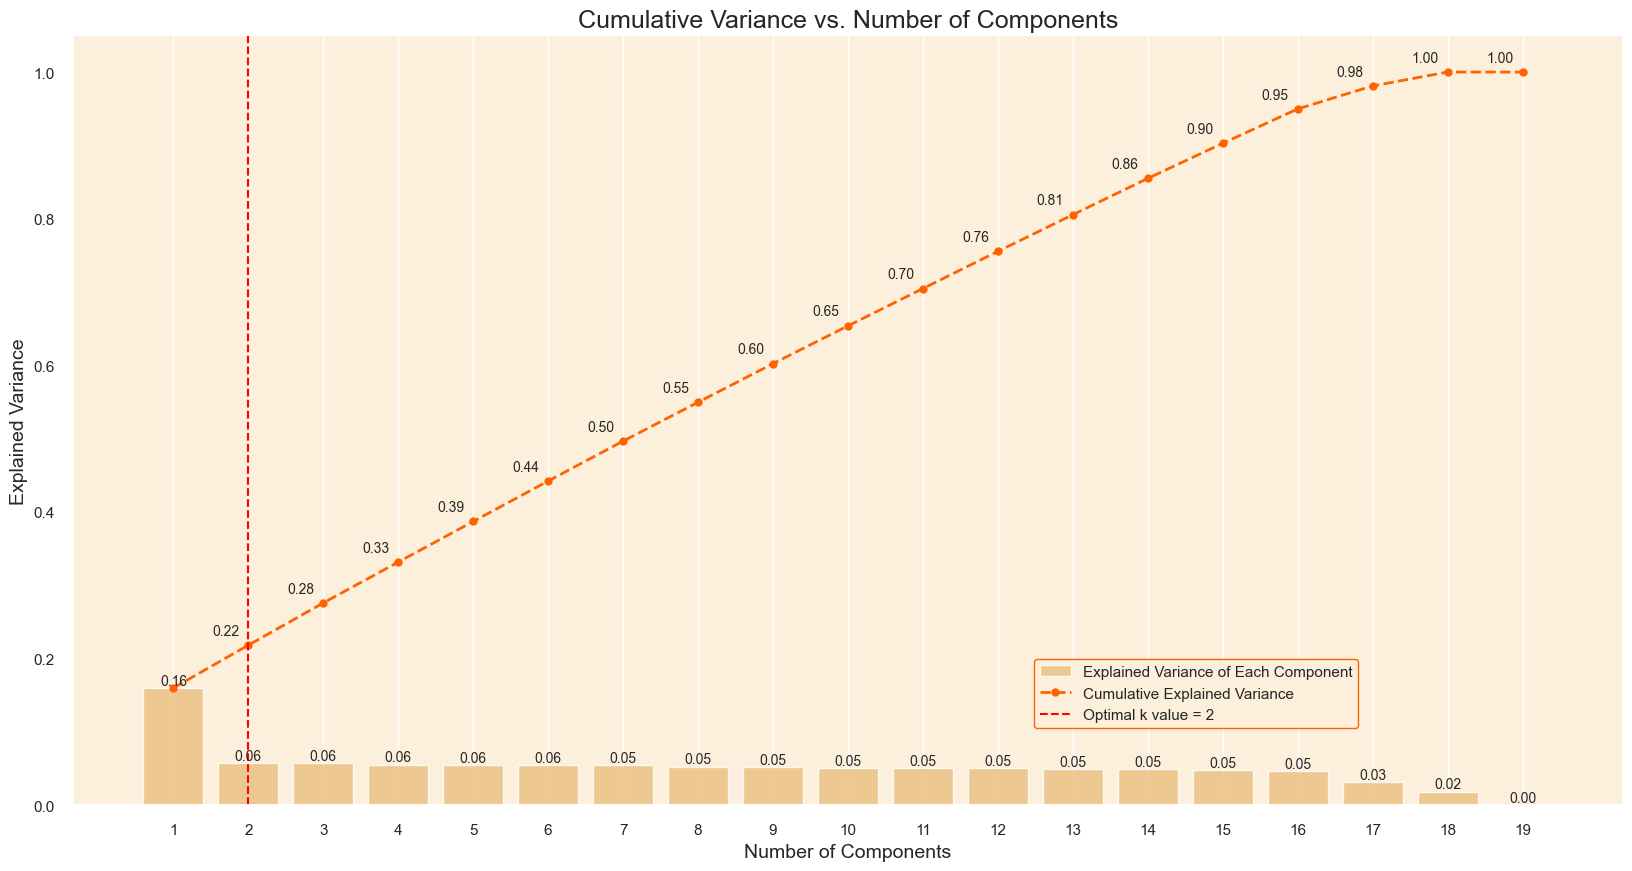

In [ ]:
# Apply PCA
pca = PCA().fit(cleaned)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 2)
optimal_k = 2

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

<h3 align="left"><font color=#ff6200>Dimensionality Reduction & Clustering Insights:</font></h3>

<font color=#000000>

To reduce dimensional complexity and enable effective visualization, Principal Component Analysis (PCA) was applied to the feature space. While only the top 2 principal components were retained, capturing approximately 22% of the total variance, they were sufficient to reveal distinct, well-separated clusters when fed into the DBSCAN algorithm.

Despite the relatively low explained variance, the clustering yielded 4 meaningful customer segments, each exhibiting coherent behavioral patterns. This suggests that even limited dimensional representation preserved enough structure in the data for DBSCAN to detect underlying densities and outliers effectively.

Furthermore, the recommendations generated per cluster aligned well with customer behavior, validating both the segmentation and the downstream recommendation system.

In [30]:
# Creating a PCA object with 2 components
pca = PCA(n_components=2)

# Fitting and transforming the original data to the new PCA dataframe
pca_df = pca.fit_transform(cleaned)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
pca_df = pd.DataFrame(pca_df, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

pca_df

PC1       PC2
0     2.315798  0.081511
1     2.246723  1.298251
2     2.310841 -0.344231
3     2.386824  0.253524
4     2.363054 -0.137609
...        ...       ...
3895 -1.781899  0.654219
3896 -1.802196 -0.375786
3897 -1.790889  0.190044
3898 -1.874095 -0.442856
3899 -1.821924 -0.428137

[3900 rows x 2 columns]

In [31]:
df.head()

Customer_ID  Age Gender Item_Purchased  Category  Purchase_Amount_USD       Location Size      Color  Season  Review_Rating Subscription_Status Payment_Method  Shipping_Type Discount_Applied Promo_Code_Used  Previous_Purchases Preferred_Payment_Method Frequency_of_Purchases is_ppm
0            1   55   Male         Blouse  Clothing                   53       Kentucky    L       Gray  Winter            3.1                 Yes    Credit Card        Express              Yes             Yes                  14                    Venmo            Fortnightly     No
1            2   19   Male        Sweater  Clothing                   64          Maine    L     Maroon  Winter            3.1                 Yes  Bank Transfer        Express              Yes             Yes                   2                     Cash            Fortnightly     No
2            3   50   Male          Jeans  Clothing                   73  Massachusetts    S     Maroon  Spring            3.1                 Yes           Cash  Free Shipping              Yes             Yes                  23              Credit Card                 Weekly     No
3            4   21   Male        Sandals  Footwear                   90   Rhode Island    M     Maroon  Spring            3.5                 Yes         PayPal   Next Day Air              Yes             Yes                  49                   PayPal                 Weekly    Yes
4            5   45   Male         Blouse  Clothing                   49         Oregon    M  Turquoise  Spring            2.7                 Yes           Cash  Free Shipping              Yes             Yes                  31                   PayPal               Annually     No

In [32]:
pca_df.head()

PC1       PC2
0  2.315798  0.081511
1  2.246723  1.298251
2  2.310841 -0.344231
3  2.386824  0.253524
4  2.363054 -0.137609

Silhouette Score: 0.28


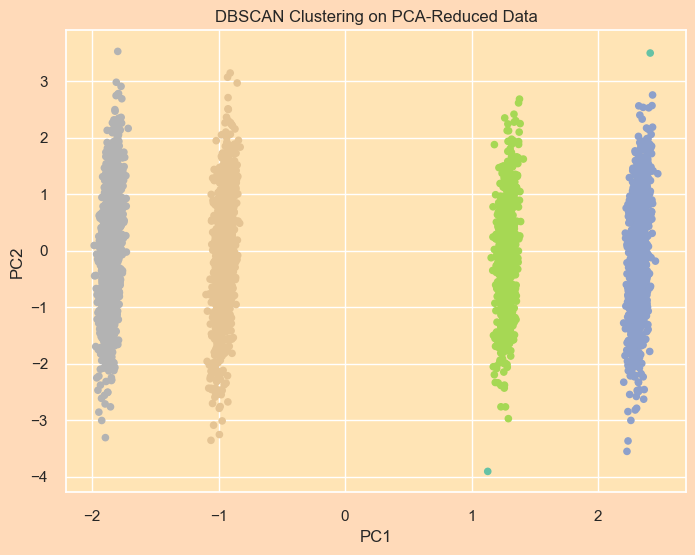

In [33]:
# Step 1: DBSCAN on 2D PCA data
pca_data = np.array(pca_df)
dbscan = DBSCAN(eps=.6, min_samples=3)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(pca_data)

# Step 2: Silhouette Score
# Remove noise points (label = -1) before scoring
valid_mask = dbscan_labels != -1
if len(set(dbscan_labels[valid_mask])) > 1:  # Need at least 2 clusters to compute silhouette
    score = silhouette_score(pca_data[valid_mask], dbscan_labels[valid_mask])
    print(f"Silhouette Score: {score:.2f}")
else:
    print("Not enough clusters for silhouette score.")

# Step 3: Plotting
fig, ax = plt.subplots(figsize=(8, 6), facecolor='peachpuff')  # outer (paper)
ax.set_facecolor('moccasin')  # inner (plot area)
scatter = plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_labels, cmap='Set2', s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DBSCAN Clustering on PCA-Reduced Data')
plt.grid(True)
plt.show()


In [34]:
pca_df['cluster'] = dbscan_labels
pca_df

PC1       PC2  cluster
0     2.315798  0.081511        0
1     2.246723  1.298251        0
2     2.310841 -0.344231        0
3     2.386824  0.253524        0
4     2.363054 -0.137609        0
...        ...       ...      ...
3895 -1.781899  0.654219        3
3896 -1.802196 -0.375786        3
3897 -1.790889  0.190044        3
3898 -1.874095 -0.442856        3
3899 -1.821924 -0.428137        3

[3900 rows x 3 columns]

In [35]:
np.unique(dbscan_labels)

array([-1,  0,  1,  2,  3])

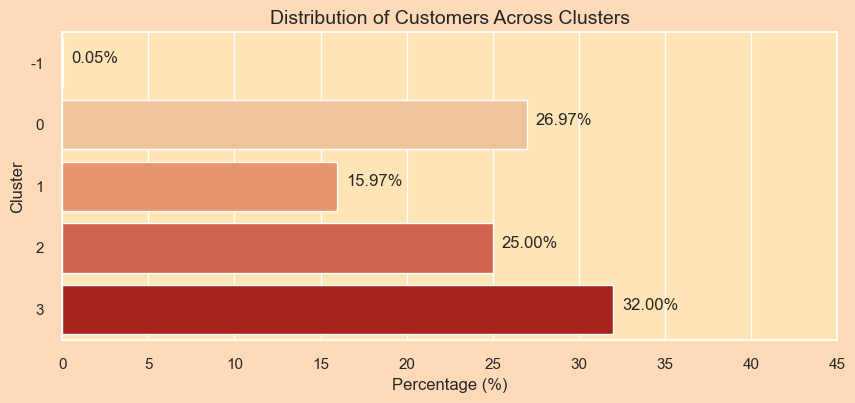

In [36]:
cluster_percentage = (pca_df['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

fig, ax = plt.subplots(figsize=(10, 4), facecolor='peachpuff')  # outer (paper)
ax.set_facecolor('moccasin')  # inner (plot area)
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette='OrRd')

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()


In [37]:
# Compute number of customers
num_observations = len(pca_df)

# Separate the features and the cluster labels
X = pca_df.drop('cluster', axis=1)
clusters = pca_df['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate.tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))


+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        3900        |
|    Silhouette Score     | 0.2800383012183389 |
| Calinski Harabasz Score | 2673.1886128484416 |
|  Davies Bouldin Score   | 5.914179982028718  |
+-------------------------+--------------------+


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Dropping -ve cluster points as they represent only 2 samples of the entire Data (0.05%).

In [38]:
neg_cluster = pca_df[pca_df['cluster'] == -1].index
df.drop(index=neg_cluster, inplace=True)
pca_df.drop(index=neg_cluster, inplace=True)
cleaned.drop(index=neg_cluster, inplace=True)
print("Dropped neg cluster")

Dropped neg cluster


<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

New Shape:

In [39]:
pca_df.shape, df.shape, cleaned.shape

((3898, 3), (3898, 20), (3898, 19))

In [40]:
test = pd.merge(df, pca_df, on=df.index, how='outer')
test.drop(['PC1', 'PC2', 'key_0'], axis=1, inplace=True)

test.head()

Customer_ID  Age Gender Item_Purchased  Category  Purchase_Amount_USD       Location Size      Color  Season  Review_Rating Subscription_Status Payment_Method  Shipping_Type Discount_Applied Promo_Code_Used  Previous_Purchases Preferred_Payment_Method Frequency_of_Purchases is_ppm  cluster
0            1   55   Male         Blouse  Clothing                   53       Kentucky    L       Gray  Winter            3.1                 Yes    Credit Card        Express              Yes             Yes                  14                    Venmo            Fortnightly     No        0
1            2   19   Male        Sweater  Clothing                   64          Maine    L     Maroon  Winter            3.1                 Yes  Bank Transfer        Express              Yes             Yes                   2                     Cash            Fortnightly     No        0
2            3   50   Male          Jeans  Clothing                   73  Massachusetts    S     Maroon  Spring            3.1                 Yes           Cash  Free Shipping              Yes             Yes                  23              Credit Card                 Weekly     No        0
3            4   21   Male        Sandals  Footwear                   90   Rhode Island    M     Maroon  Spring            3.5                 Yes         PayPal   Next Day Air              Yes             Yes                  49                   PayPal                 Weekly    Yes        0
4            5   45   Male         Blouse  Clothing                   49         Oregon    M  Turquoise  Spring            2.7                 Yes           Cash  Free Shipping              Yes             Yes                  31                   PayPal               Annually     No        0

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
<font color=#000000>

Analyzing each cluster's behaviour:

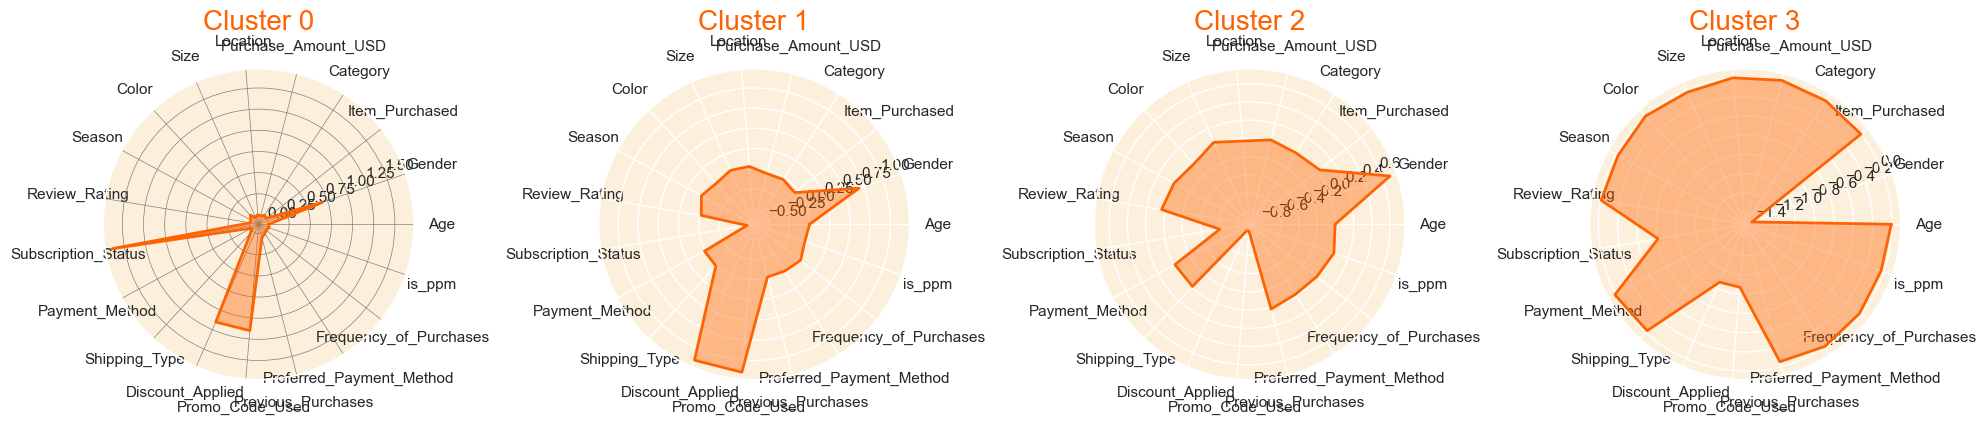

In [41]:
# Add cluster data to the cleaned data set
cleaned['cluster'] = test['cluster']

# Calculate the centroids of each cluster
cluster_centroids = cleaned.groupby('cluster').mean()

num_clusters = cluster_centroids.shape[0]

colors = ['#ff6200']* num_clusters

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(5*num_clusters, 10), 
                       subplot_kw=dict(polar=True), 
                       nrows=1, ncols=num_clusters)

# Ensure ax is always iterable
if num_clusters == 1:
    ax = [ax]

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

ax[3].set_xticks(angles[:-1])
ax[3].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


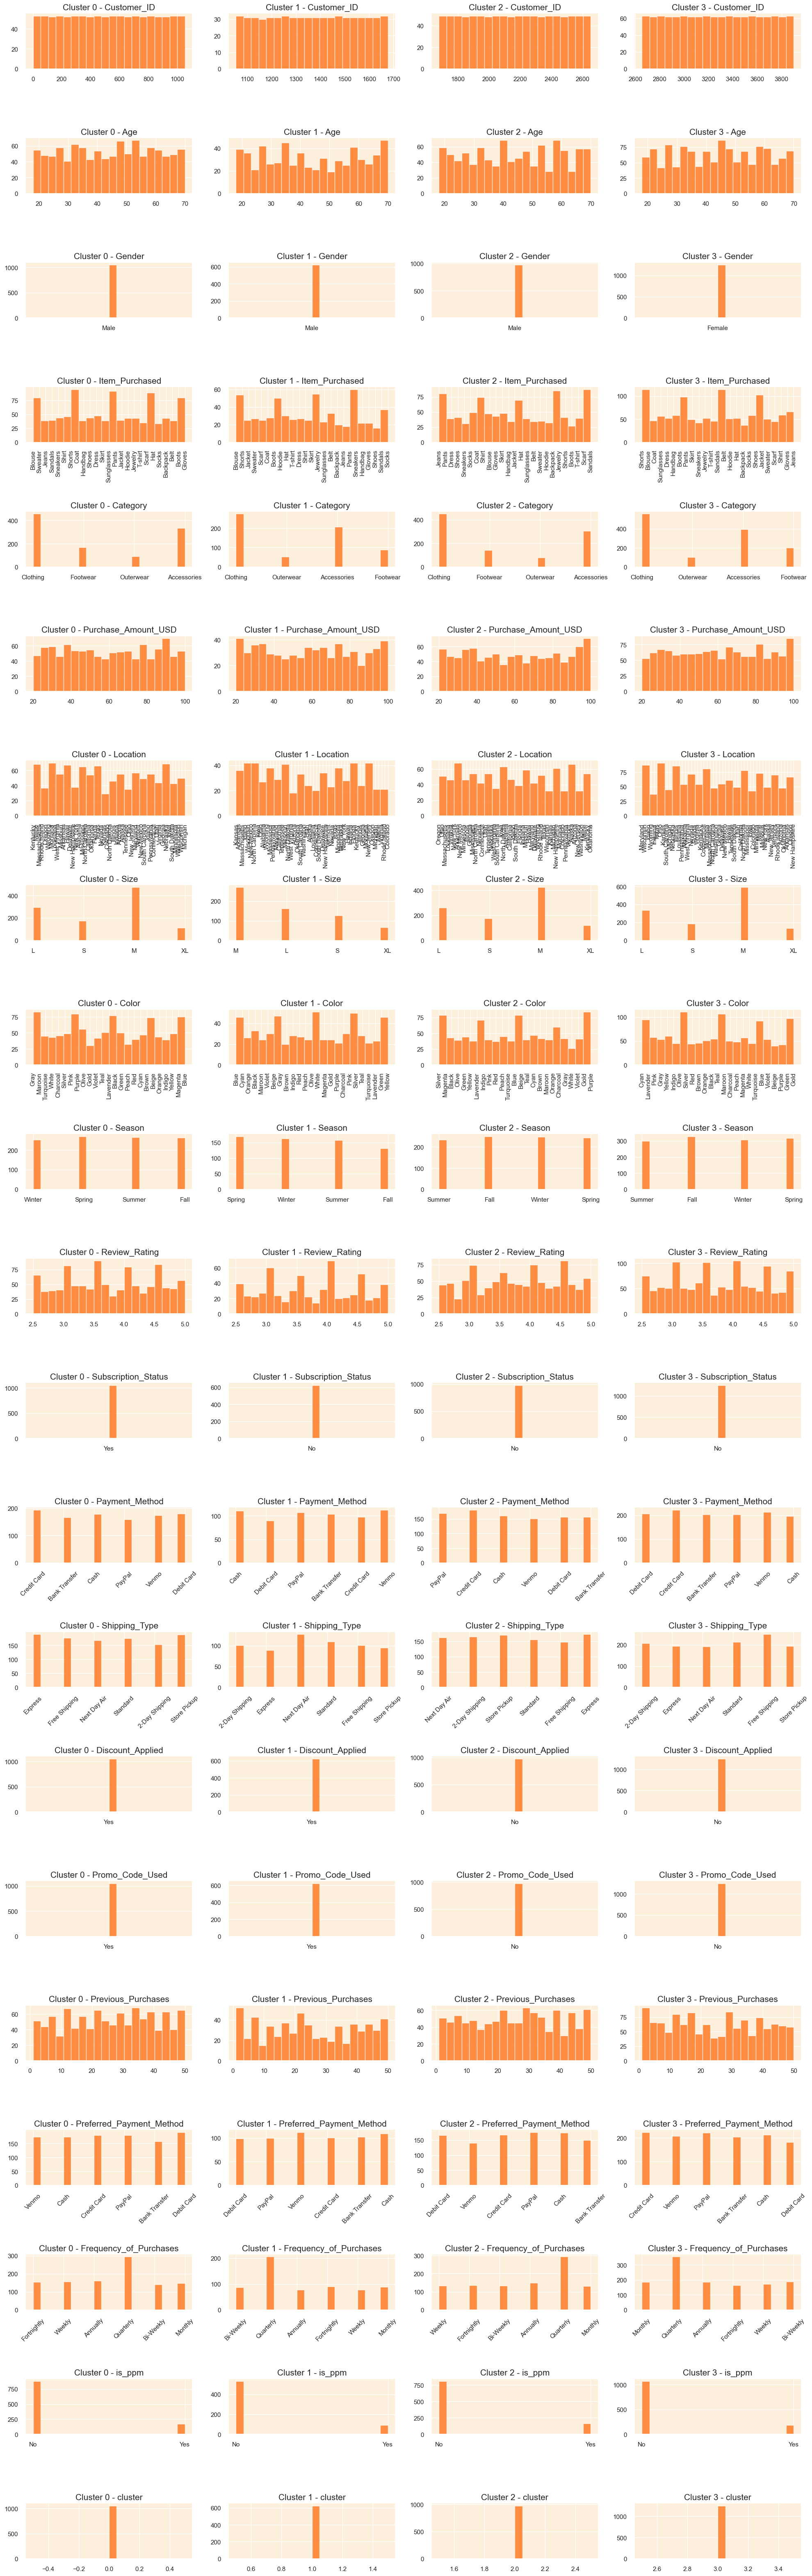

In [42]:
# Plot histograms for each feature segmented by the clusters
colors = ['#ff6200']* (num_clusters+1)

features = test.columns
clusters = test['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows),)

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = test[test['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')
        if feature in ['Item_Purchased', 'Location', 'Color']:
            axes[i, j].tick_params(axis='x', labelrotation=90)
        elif feature in ['Payment_Method', 'Shipping_Type', 'Preferred_Payment_Method', 'Frequency_of_Purchases']:
            axes[i, j].tick_params(axis='x', labelrotation=45)


# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">
    
<h2 align="left"><font color=#ff6200>Customer Profiles Derived from Radar Chart Analysis</font></h2>
    
<h3 align="left"><font color=#ff6200>Cluster 0</font></h3>

<font color=#000000>

üéØ Profile: __The Discounted Subscriber__  

* **Deep Behavioral Analysis:** This cluster represents the most valuable customer segment. Their "Yes" on subscription status indicates a strong commitment to the brand, likely driven by the perceived value of an ongoing relationship. Their high usage of discounts and promo codes suggests that these are not just loyalty benefits but a key part of what keeps them engaged and purchasing frequently. They aren't just subscribers; they are *actively leveraging* the perks of their subscription. Their preference for clothing and accessories indicates they are fashion-conscious and likely update their wardrobe regularly. The high purchase amount coupled with high frequency suggests they are not just buying sale items but are making substantial, recurring purchases.

* **Business Implications & Strategy:** This is the segment to nurture and retain.
    * **Retention:** Focus on enhancing the subscription benefits. Offer exclusive products or early access to new collections.
    * **Monetization:** They are responsive to promotions, so use targeted discounts to encourage higher-value purchases or to cross-sell from clothing to outerwear, for example.
    * **Marketing:** Highlight the value of the subscription service in all marketing communications. Use their positive review ratings as social proof to attract similar customers.

____
    
<h3 align="left"><font color=#ff6200>Cluster 1</font></h3>    
 
üéØ Profile: __The Non-Subscriber Bargain Hunter__  
    
* **Deep Behavioral Analysis:** This cluster is the classic "bargain hunter." The "No" for subscription and "Yes" for discounts and promo codes reveal a customer who is not loyal to the brand itself, but to the *deal*. Their lower purchase amount and moderate frequency suggest they are opportunistic buyers who purchase when an item they like goes on sale, rather than making regular, planned purchases. They are less about brand loyalty and more about product value. Their preference for accessories and outerwear might indicate they are looking for specific, non-essential items to complete an outfit, rather than building a foundational wardrobe.

* **Business Implications & Strategy:** This is a segment that can be converted but requires a different approach.
    * **Conversion:** The primary goal should be to convert them into subscribers. Offer a trial subscription with an exclusive discount on their next purchase. Frame the subscription as a way to get *consistent* deals, not just one-off discounts.
    * **Monetization:** Use flash sales and limited-time offers to trigger purchases. Avoid generic marketing; instead, use personalized ads based on their past Browse and purchase history to show them deals on items they are likely to want.
    * **Marketing:** Emphasize the monetary savings and value proposition in all ads.

____
    
<h3 align="left"><font color=#ff6200>Cluster 2</font></h3>    

üéØ Profile: __The Non-Discounted Male Shopper__
    
* **Deep Behavioral Analysis:** This customer is the opposite of Cluster 1. The complete absence of promo code or discount usage, coupled with a "No" for subscription status, indicates a customer who is driven by necessity, not deals. They buy what they need, when they need it, at the regular price. Their purchase behavior is very straightforward and functional. They are not looking for a "shopping experience" but a transactional one. The preference for outerwear and accessories suggests they are buying specific, possibly durable, items. Their moderate frequency and low purchase amount point to a consumer who is buying a few items at a time, but on a somewhat regular basis, possibly replacing worn-out items.

* **Business Implications & Strategy:** This segment is about efficiency and product quality.
    * **Conversion:** Trying to convert them with discounts is unlikely to work. Instead, focus on the brand's reputation for quality, durability, and convenience. Offer fast shipping and a seamless purchasing experience.
    * **Monetization:** Since they are not price-sensitive, focus on upselling and cross-selling based on utility. For example, if they buy a winter coat, suggest a scarf and gloves.
    * **Marketing:** Highlight product features, quality materials, and customer service. Testimonials from other utilitarian buyers would be more effective than ads promising discounts.

____
    
<h3 align="left"><font color=#ff6200>Cluster 3</font></h3>    

üéØ Profile: __The High-Spending Female Shopper__

* **Deep Behavioral Analysis:** This is a high-value, high-spending, and frequent customer. Their female demographic sets them apart, as does their high purchase amount. The "No" on discounts and promos shows they are not price-sensitive. They are purchasing for reasons other than a deal, likely brand affinity, quality, or a positive shopping experience. Their high frequency of monthly purchases suggests they are either avid fashion consumers or they are purchasing for family, friends, or a business. Their heavy preference for large and medium sizes might also indicate they are buying for multiple people or prefer a looser fit.

* **Business Implications & Strategy:** This is the most profitable segment, so the focus is on retention and brand building.
    * **Retention:** Do not annoy them with discount-focused emails. Instead, offer exclusive brand experiences, early access to new collections (not just discounts), and personalized recommendations.
    * **Monetization:** Introduce a tiered loyalty program that rewards their high spending with non-monetary benefits like exclusive events or a dedicated personal shopper.
    * **Marketing:** Focus on aspirational brand messaging. Highlight the quality, design, and exclusivity of your products. Use aspirational imagery and storytelling. Target them with campaigns that emphasize the emotional connection to the brand, not just the product.



<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:120%; text-align:left">

<h3 align="left"><font color=#ff6200>Recommendation Engine Approach:</font></h3>

<font color=#000000>

1) Get the top 3 best selling products per each cluster.
2) Capture each customer's cluster.
3) Return the product in it's most purchased color.

In [43]:
best_selling_products = test.groupby(['cluster', 'Item_Purchased'])['Purchase_Amount_USD'].sum().sort_values(ascending=False).reset_index()

recs = []
for cluster in sorted(test['cluster'].unique()):
    products = best_selling_products[best_selling_products['cluster'] == cluster]['Item_Purchased'].head(3).values
    recs.append(products)

ids = test['Customer_ID'].sample(10)
table_rows = []
for id in ids:
    row = test[test['Customer_ID'] == id]
    cluster = int(row['cluster'])
    recs_per_cluster = recs[cluster]
    details = """"""
    for i, pro in enumerate(recs_per_cluster):
        temp = test.groupby(['cluster', 'Item_Purchased', 'Color']).size().reset_index(name='count')
        most_used_colors = temp.loc[temp.groupby(['cluster', 'Item_Purchased'])['count'].idxmax()]
        cond1 = most_used_colors['cluster'] == cluster
        cond2 = most_used_colors['Item_Purchased'] == pro
        color = most_used_colors['Color'][(cond1) & (cond2)].values[0]
        details += str('[' + str(i+1) + ']' + ' ' + color + ' ' + pro + '\n')

    table_rows.append([id, f'Cluster {cluster}', details])

print(tabulate.tabulate(table_rows, headers=['Customer ID', 'Cluster', 'Recommendations'], tablefmt='fancy_grid'))

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï§‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ   Customer ID ‚îÇ Cluster   ‚îÇ Recommendations    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ          2954 ‚îÇ Cluster 3 ‚îÇ [1] Violet Blouse  ‚îÇ
‚îÇ               ‚îÇ           ‚îÇ [2] Charcoal Shirt ‚îÇ
‚îÇ               ‚îÇ           ‚îÇ [3] Teal Dress     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ           986 ‚îÇ Cluster 0 ‚îÇ [1] Cyan Sweater   ‚îÇ
‚îÇ               ‚îÇ           ‚îÇ [2] Charcoal Pants ‚îÇ
‚îÇ               ‚îÇ           ‚îÇ [3] Silver Coat    ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î